In [43]:
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

In [44]:
finetuned_bart = BARTModel.from_pretrained('/home/ml/users/cadencao/fairseq/checkpoints/xsum_cmlm_bos',
                                           checkpoint_file='checkpoint_best.pt',
                                           data_name_or_path='/home/ml/users/cadencao/XSum/fairseq_files/xsum-bin')

In [45]:
finetuned_bart.cuda()
finetuned_bart.eval()
finetuned_bart.half()
print('- fine-tuned bart model loaded.')

- fine-tuned bart model loaded.


In [46]:
bart = BARTModel.from_pretrained('/home/ml/users/cadencao/Downloads/BART_models/bart.large',
                                 checkpoint_file='model.pt',
                                 data_name_or_path='/home/ml/users/cadencao/Downloads/BART_models/bart.large')

In [47]:
bart.cuda()
bart.eval()
bart.half()
print('- bart model loaded.')

- bart model loaded.


In [48]:
encode_func = bart.encode
decode_func = bart.decode

#### Read XSum

In [49]:
document_path = '/home/ml/users/cadencao/XSum/fairseq_files/test.source'
target_path = '/home/ml/users/cadencao/XSum/fairseq_files/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Generate Summary

In [50]:
from fairseq.data.data_utils import collate_tokens

In [51]:
def tokenize(src_input, verbose=False):
    src_inputs = [src_input]  # list of input string
    src_tokens = collate_tokens([encode_func(i) for i in src_inputs], pad_idx=1, left_pad=True)
    src_tokens = src_tokens.cuda()
    src_lengths = torch.sum(src_tokens != 1, dim=1)
    
    if verbose:
        print('- src tokens: {};\n- src lengths: {}'.format(src_tokens.shape, src_lengths.shape))
    return src_tokens, src_lengths

In [52]:
def tokenize_with_mask(input_sentence):
    bpe_code = bart.bpe.encode(input_sentence)  # <mask>: 1279 27932 29
    input_ids = bart.task.source_dictionary.encode_line('<s> ' + bpe_code.replace('1279 27932 29', '<mask>'), 
                                                        append_eos=True).long()
    input_ids = input_ids.unsqueeze(0).cuda()
    src_lengths = torch.sum(input_ids != 1, dim=1)
    return input_ids, src_lengths

In [53]:
def generate_sequence(decoder, encoder_out, batch_size=1, tgt_tokens=None, min_decode_step=1, max_decode_step=100, pad_id=1, eos_id=2, verbose=True):
    init_input = torch.tensor([[2, 0]] * batch_size, dtype=torch.long).cuda()
    softmax = nn.Softmax(dim=1)
    token_probs, tokens = [], []

    for step in range(max_decode_step):
        decoder_outputs = decoder(init_input, encoder_out, features_only=False)
        logits = decoder_outputs[0][:, -1, :]  # [batch_size, vocab]
        
        if step + 1 < min_decode_step:
            logits[:, eos_id] = -math.inf
        logits[:, pad_id], logits[:, 0] = -math.inf, -math.inf  # never select pad, start token

        probs = softmax(logits)
        assert logits.shape == probs.shape
        attn = decoder_outputs[1]['attn'][0]  # [batch_size, prev_token_len, src_token_len]
        assert logits.dim() == 2 and attn.dim() == 3

        if tgt_tokens is not None:
            selected_token = tgt_tokens[step].unsqueeze(0)
        else:
            value, indices = torch.topk(probs, 5, dim=1)
            selected_token = indices[:, 0]

        init_input = torch.cat([init_input, selected_token.unsqueeze(1)], dim=-1)
        token, prob = decode_func(selected_token), probs.squeeze()[selected_token.item()].item()
        
        if selected_token.item() == eos_id:
            break
        elif verbose:
            print("- {:02d}: {} ({:.2f})".format(step, token, prob), end='\n')

        token_probs.append(prob)
        tokens.append(token)

    return init_input, tokens, token_probs

In [54]:
def get_probability(position, tokens, probs, entity):
    """Get probability of the given target.

    Args:
        position: (start, end)
        tokens: ['The', ' Archbishop', ' of', ...]
        probs: [0.50, 0.49, 0.88, ...]
        entity: Rodgers
    """
    assert len(tokens) == len(probs)
    
    end_pointer, end_pos = 0, []
    for t in tokens:
        end_pointer += len(t)
        end_pos.append(end_pointer)
    
    assert position[1] in end_pos, "- {}\n- {}\n- {}\n- {}\n- {}\n".format(position, tokens, probs, entity, end_pos)
    last_index = end_pos.index(position[1])
    indexes = [last_index]
    total_length = len(tokens[last_index])
    
    while total_length < (position[1] - position[0]):
        last_index -= 1
        assert last_index >= 0
        indexes.append(last_index)
        total_length += len(tokens[last_index])
    
    indexes.reverse()
    
    generated = ''.join([tokens[i] for i in indexes])
    assert entity in generated, 'entity: {}; prob calculated: {}'.format(entity, generated)
    
    prob = 1.0
    for i in indexes:
        prob *= probs[i]
    return prob

In [55]:
def get_cmlm_probability(bart_model, sentence, masked_sentence, position, entity, verbose=False):
    masked_input, masked_lengths = tokenize(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input,
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=bart_model.encode(sentence)[1:].cuda(),
                                       verbose=verbose)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    assert decode_func(masked_output_ids[0]) == sentence
    assert ''.join(masked_tokens) == sentence
    
    return get_probability(position, masked_tokens, masked_token_probs, entity)

In [56]:
def get_prior_probability(bart_model, sentence, masked_sentence, position, entity, verbose=False):
    masked_input, masked_lengths = tokenize_with_mask(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input,
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=bart_model.encode(sentence)[1:].cuda(),
                                       verbose=verbose)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    assert decode_func(masked_output_ids[0]) == sentence, '{}; {}'.format(decode_func(masked_output_ids[0]), sentence)

    return get_probability(position, masked_tokens, masked_token_probs, entity)

In [57]:
def cmlm_generate(bart_model, masked_sentence, verbose=False):
    masked_input, masked_lengths = tokenize(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input, 
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=None,
                                       verbose=verbose)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    
    return decode_func(masked_output_ids[0])

In [58]:
def prior_generate(bart_model, masked_sentence):
    masked_input, masked_lengths = tokenize_with_mask(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input, 
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=None,
                                       verbose=False)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    
    return decode_func(masked_output_ids[0])

#### Get Conditional Probability

In [59]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [60]:
INDEX = 9444

In [61]:
source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."
print(target)

ent_parts = nlp(target).to_json()['ents']
print(ent_parts, end='\n\n')

for e in ent_parts:
    entity = target[e['start']: e['end']]
    
    with torch.no_grad():
        masked_hypothesis = target[0: e['start']] + '<mask>' + target[e['end']:]
        prior = get_prior_probability(bart, target, masked_hypothesis, (e['start'], e['end']), entity)
        print(target[0: e['start']] + '<mask>' + target[e['end']:])
#         print('- prior: {}'.format(prior_generate(bart, masked_hypothesis)))

        masked_hypothesis = target[0: e['start']] + '###' + target[e['end']:]
        masked_hypothesis = '<s> ' + masked_hypothesis + ' <\s> ' + source
        posterior = get_cmlm_probability(finetuned_bart,
                                         '<s> ' + target,
                                         masked_hypothesis,
                                         (e['start'] + 4, e['end'] + 4),
                                         entity, verbose=False)
#         print(target[0: e['start']] + '###' + target[e['end']:])
#         print('- posterior: {}'.format(cmlm_generate(finetuned_bart, masked_hypothesis, verbose=False)))

        print('- entity: {}'.format(entity))
        print('- prior: {}'.format(prior))
        print('- posterior: {}'.format(posterior))
        print('- ratio: {:.3f} / {:.3f} = {:.3f}'.format(posterior, prior, posterior / (prior + 1e-5)))
        print()

Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
[{'start': 35, 'end': 39, 'label': 'ORG'}, {'start': 75, 'end': 82, 'label': 'ORG'}]

Twin-to-twin transfusion syndrome (<mask>) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
- entity: TTTS
- prior: 0.00037639751099050045
- posterior: 0.7503890991210938
- ratio: 0.750 / 0.000 = 1942.013

Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in <mask> in a bid to save the lives of babies born with the condition.
- entity: Cardiff
- prior: 0.0011739730834960938
- posterior: 0.1402587890625
- ratio: 0.140 / 0.001 = 118.465



#### Read Annotated Data

In [62]:
import json

from tqdm import tqdm

In [63]:
data = json.load(open('annotated.json', 'r'))
print(len(data))

107


In [64]:
data[55]

{'id': 5747,
 'pred': 'Six teenagers have died from carbon monoxide poisoning after a party at a remote hut in northern Germany, police say.',
 'ents': [{'start': 0, 'end': 3, 'label': 0, 'type': 'CARDINAL', 'ent': 'Six'},
  {'start': 97, 'end': 104, 'label': 0, 'type': 'GPE', 'ent': 'Germany'}],
 'hallucinations': []}

In [65]:
for INDEX in tqdm(range(len(data))):
    source = xsum_source[data[INDEX]['id']]
    
    for i, e in enumerate(data[INDEX]['ents']):
        target = data[INDEX]['pred']
        entity = e['ent']
        
        with torch.no_grad():
            masked_hypothesis = target[0: e['start']] + '<mask>' + target[e['end']:]
            prior = get_prior_probability(bart, target, masked_hypothesis, (e['start'], e['end']), entity)
            
            masked_hypothesis = '<s> ' + target[0: e['start']] + '###' + target[e['end']:]
            masked_input = masked_hypothesis + ' <\s> ' + source
            posterior = get_cmlm_probability(finetuned_bart,
                                             '<s> ' + target,
                                             masked_input,
                                             (e['start'] + 4, e['end'] + 4),
                                             entity, verbose=False)

#             print('- posterior int: {}'.format(masked_hypothesis))
#             print('- posterior out: {}'.format(cmlm_generate(finetuned_bart, masked_input, verbose=False)))

            e['prior'], e['posterior'] = prior, posterior

100%|██████████| 107/107 [14:54<00:00,  8.36s/it]


In [66]:
# import json

In [67]:
# with open('prior_posterior.json', 'w') as fout:
#     json.dump(prior_posterior , fout)

#### Draw Diagram

In [68]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [69]:
%matplotlib inline

import matplotlib.pyplot as plt

In [70]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        prior_posterior.append(e)

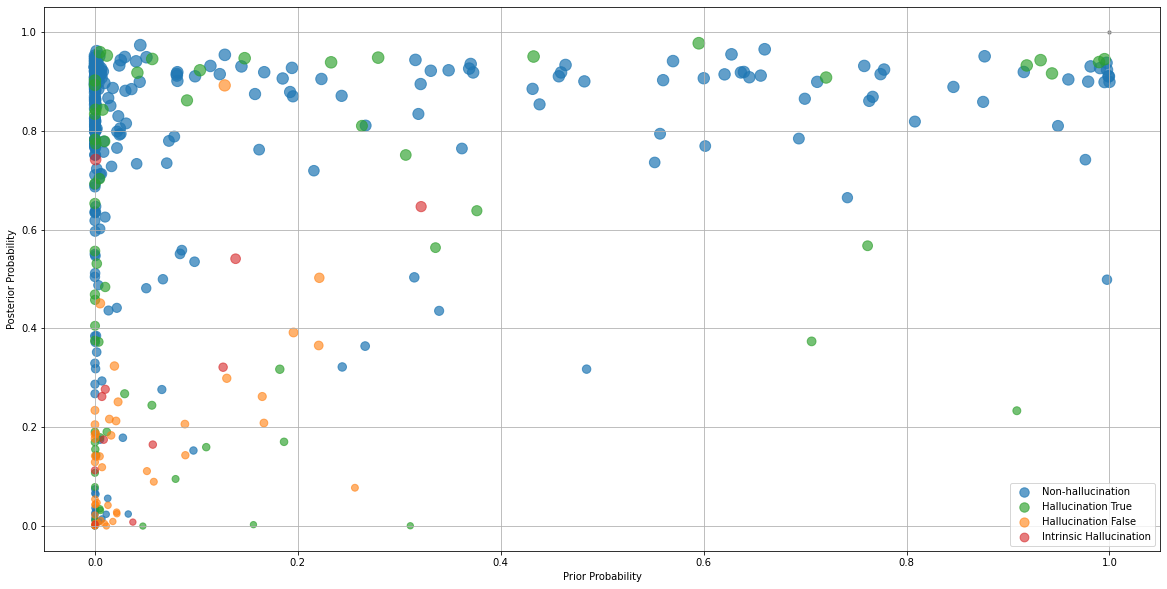

In [71]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]
hallucinated_intrinsic = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]

ax.scatter([i[0] for i in no_hallucinated], 
           [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)

ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([i[0] for i in hallucinated_intrinsic], 
           [i[1] for i in hallucinated_intrinsic], c='tab:red', s=[i[1]*100 + 40 for i in hallucinated_intrinsic], label='Intrinsic Hallucination', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [72]:
for p in prior_posterior:
    if p['label'] == 2 and p['posterior'] > 0.3:
        print(p)

{'start': 62, 'end': 75, 'label': 2, 'type': 'CARDINAL', 'ent': 'more than 100', 'prior': 0.019222929695388302, 'posterior': 0.3239011822734028, 'id': 8805}
{'start': 25, 'end': 33, 'label': 2, 'type': 'PERSON', 'ent': 'Federico', 'prior': 0.00511079840362072, 'posterior': 0.450597882270813, 'id': 1431}
{'start': 34, 'end': 39, 'label': 2, 'type': 'PERSON', 'ent': 'Fazio', 'prior': 0.12790367903653532, 'posterior': 0.891750423470512, 'id': 1431}
{'start': 96, 'end': 117, 'label': 2, 'type': 'DATE', 'ent': 'the end of the season', 'prior': 0.19574056990308009, 'posterior': 0.39181228401330537, 'id': 8685}
{'start': 7, 'end': 14, 'label': 2, 'type': 'GPE', 'ent': 'England', 'prior': 0.22119140625, 'posterior': 0.50244140625, 'id': 3030}
{'start': 70, 'end': 76, 'label': 2, 'type': 'ORDINAL', 'ent': 'second', 'prior': 0.2205810546875, 'posterior': 0.365478515625, 'id': 9166}


#### Classification

In [73]:
prior_posterior[0]

{'start': 62,
 'end': 75,
 'label': 2,
 'type': 'CARDINAL',
 'ent': 'more than 100',
 'prior': 0.019222929695388302,
 'posterior': 0.3239011822734028,
 'id': 8805}

In [74]:
true_label = []
ent_pred_label = []
prob_pred_label = []

for p in prior_posterior:
    if p['label'] is not None:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            ent_pred_label.append(0)
        else:
            ent_pred_label.append(1)

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(0)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))

        if p['posterior'] > 0.2:
            prob_pred_label.append(0)
        else:
            prob_pred_label.append(1)

In [75]:
from sklearn.metrics import classification_report

In [76]:
print(classification_report(true_label, ent_pred_label, target_names=['Non-factual', 'Factual']))

              precision    recall  f1-score   support

 Non-factual       0.96      0.69      0.81       314
     Factual       0.33      0.86      0.48        56

    accuracy                           0.72       370
   macro avg       0.65      0.77      0.64       370
weighted avg       0.87      0.72      0.76       370



In [77]:
print(classification_report(true_label, prob_pred_label, target_names=['Non-factual', 'Factual']))

              precision    recall  f1-score   support

 Non-factual       0.93      0.88      0.90       314
     Factual       0.48      0.62      0.54        56

    accuracy                           0.84       370
   macro avg       0.70      0.75      0.72       370
weighted avg       0.86      0.84      0.85       370



#### AUC

In [78]:
import numpy as np

from sklearn.metrics import roc_curve, auc

In [79]:
prior_posterior[0]

{'start': 62,
 'end': 75,
 'label': 2,
 'type': 'CARDINAL',
 'ent': 'more than 100',
 'prior': 0.019222929695388302,
 'posterior': 0.3239011822734028,
 'id': 8805}

In [80]:
# non-hallucination vs false hallucination

In [81]:
true_label = []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None:

        if p['label'] == 0 or p['label'] == 1:
            true_label.append(1)
        elif p['label'] == 2 or p['label'] == 3:
            true_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
        
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [82]:
true_label = np.asarray(true_label)
prior_probabilities = np.asarray(prior_probabilities)
posterior_probabilities = np.asarray(posterior_probabilities)

In [83]:
true_label.shape

(370,)

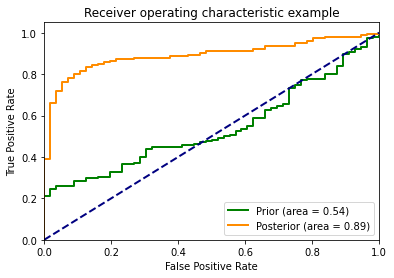

In [84]:
plt.figure()
lw = 2

# prior
fpr, tpr, _ = roc_curve(true_label, prior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',
         lw=lw, label='Prior (area = %0.2f)' % roc_auc)

# posterior
fpr, tpr, _ = roc_curve(true_label, posterior_probabilities)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Posterior (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()